In [1]:
from sklearn.datasets import fetch_openml

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')

# Print the keys of the dataset
print(mnist.keys())


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black). 

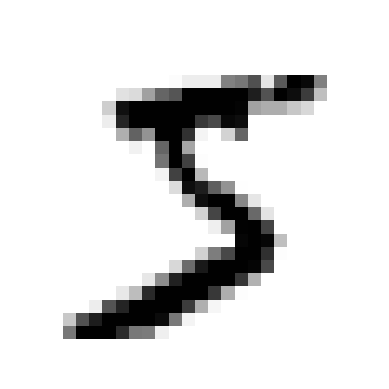

In [4]:
import matplotlib.pyplot as plt

# Select the first row of the DataFrame and store it in the variable 'some_digit'
some_digit = X.iloc[0]

# Convert the 'some_digit' Pandas Series to a NumPy array and reshape it to a 28x28 matrix
some_digit_image = some_digit.to_numpy().reshape(28, 28)

# Display the image using Matplotlib's imshow function
# Set the color map to "binary" (black and white)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [5]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to
integer:

In [6]:
import numpy as np

# Assuming 'y' is a variable you want to convert to uint8
y = y.astype(np.uint8)


In [7]:
y[0]

5

 The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images)
The training set is already shuffled for us, which is good because this guarantees that
all cross-validation folds will be similar (you don’t want one fold to be missing some
digits). Moreover, some learning algorithms are sensitive to the order of the training
instances, and they perform poorly if they get many similar instances in a row. Shuf‐
fling the dataset ensures that this won’t ha
pShuffling may be a bad idea in some contexts—for example, if you are working on time series data (such as 
stock market prices or weather conditions).spen:

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


## Training a Binary Classifier

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
# The result is assigned to the variable y_train_5. So, y_train_5 is a boolean
# array of the same length as y_train, where each element is True if the 
# corresponding digit is a 5 and False otherwise.
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

The SGDClassifier relies on randomness during training (hence
the name “stochastic”). If you want reproducible results, you
should set the random_state parameter.

In [11]:
sgd_clf.predict([some_digit])


/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# Import the BaseEstimator class from scikit-learn
from sklearn.base import BaseEstimator

# Create a custom classifier class named Never5Classifier that inherits from BaseEstimator
class Never5Classifier(BaseEstimator):
    # Define the fit method for the classifier
    def fit(self, X, y=None):
        # The fit method doesn't do anything in this case, it just returns the instance itself
        return self

    # Define the predict method for the classifier
    def predict(self, X):
        # The predict method returns an array of zeros with the same length as the input X
        # It predicts that none of the instances are the digit 5
        return np.zeros((len(X), 1), dtype=bool)


In [14]:
# Create an instance of the Never5Classifier
never_5_clf = Never5Classifier()

# Use cross_val_score to perform cross-validation and calculate accuracy scores
# This function takes the classifier (never_5_clf), the input features (X_train),
# the target labels (y_train_5), the number of folds (cv=3), and the scoring metric ("accuracy")
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradam

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).us

In [15]:
# Import the cross_val_predict function from scikit-learn
from sklearn.model_selection import cross_val_predict

# Use cross_val_predict to perform cross-validated predictions
# This function takes the classifier (sgd_clf), the input features (X_train),
# the target labels (y_train_5), the number of folds (cv=3)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [16]:
# Import the confusion_matrix function from scikit-learn
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix using the true labels (y_train_5) and predicted labels (y_train_pred)
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column repre‐
sents a predicted class. The first row of this matrix considers non-5 images (the nega‐
tive class): 53,057 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,325 were wrongly
classified as non-5s (false negatives), while the remaining 4,096 were correctly classi‐
fied as 5s (true positives). A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diago‐
nal (top left to bottom right):

In [17]:
# Pretend we have perfect predictions (y_train_perfect_predictions is the same as y_train_5)
y_train_perfect_predictions = y_train_5

# Compute the confusion matrix using the true labels (y_train_5) and perfect predictions (y_train_perfect_predictions)
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the accuracy of the positive pre‐
dictions; this is called the precision of the classifier

Equation 3-1. Precision
\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
\end{equation}
TP is the number of true positives, and FP is the number of false positives
So precision is typically used
along with another metric named recall, also called sensitivity or the true positive rate
(TPR): this is the ratio of positive instances that are correctly detected by the classifi

Equation 3-2. Recall
\begin{equation}
\text{recall} = \frac{\text{TP}}{\text{TP + FN}}
\end{equation}

FN is, of course, the number of false negatives
er.


## Precision and Recall

In [18]:
# Import the precision_score and recall_score functions from scikit-learn
from sklearn.metrics import precision_score, recall_score

# Calculate precision score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)


0.8370879772350012

In [19]:
# Calculate recall score
recall_score(y_train_5, y_train_pred)  # == 4096 / (4096 + 1325)

0.6511713705958311

When it claims an image represents a 5, it is correct only 83.7% of the time. More‐
over, it only detects 65.1% of the 5s

Recall is a crucial metric in scenarios where missing positive instances is more critical than having false positives. For example, in a medical diagnosis task, high recall would mean that the classifier is good at identifying most of the actual positive cases, even if it occasionally misclassifies some negative cases as positive.

It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1
 score is
the harmonic mean of precision and recall

In [20]:
# Import the f1_score function from scikit-learn
from sklearn.metrics import f1_score

# Calculate the F1 score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

The F1
score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other con‐
texts you really care about recall. For example, if you trained a classifier to detect vid‐
eos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐
sifier that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the clas‐
sifier’s video selection). On the other hand, suppose you train a classifier to detect
shoplifters in surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will g

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall trade-offet caught).

## Precision/Recall Trade-off


In [21]:
# Assuming you have an instance 'some_digit'

# Calculate the decision scores for the given instance using the decision_function method
y_scores = sgd_clf.decision_function([some_digit])

# Print or inspect the decision scores
y_scores


/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([ True])

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually repre‐
sents a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000.


In [24]:
# Use cross_val_predict to obtain cross-validated decision scores
# for the training data using the decision_function method
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


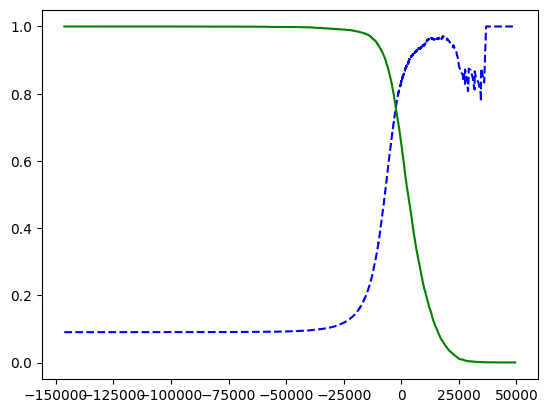

In [25]:
# Import the precision_recall_curve function from scikit-learn
from sklearn.metrics import precision_recall_curve

# Calculate precision, recall, and thresholds using precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Define a function to plot precision and recall versus threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # Plot precision versus threshold with a blue dashed line
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    
    # Plot recall versus threshold with a green solid line
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
    # Additional code to highlight the threshold, add the legend, axis labels, and grid
    # (Not provided in the given snippet, but should be added)

# Call the defined function to plot precision and recall versus threshold
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Show the plot
plt.show()


In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816
threshold_90_precision

3370.0194991439557

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
 precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

If someone says, “Let’s reach 99% precision,” you should ask, “At
what recall?”

## The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐
ting precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR). The FPR is the ratio of negative instan‐
ces that are incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified as negative.
The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) ver‐
sus 1 – specificity.

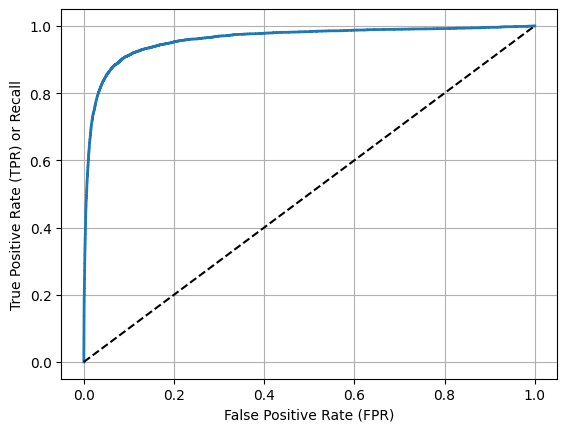

In [30]:
# Import the roc_curve function from scikit-learn
from sklearn.metrics import roc_curve

# Calculate the ROC curve values: False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Define a function to plot the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    # Plot the ROC curve with a solid line and add a label
    plt.plot(fpr, tpr, linewidth=2, label=label)
    
    # Plot the dashed diagonal line representing a random classifier
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    
    # Additional code to add axis labels and grid
    # (Not provided in the given snippet, but should be added)
    # Placeholder for additional code
    
    # Placeholder for additional code:
    # Add axis labels
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR) or Recall')
    
    # Add grid
    plt.grid(True)

# Call the defined function to plot the ROC curve
plot_roc_curve(fpr, tpr)

# Show the plot
plt.show()


One way to compare classifiers is to measure the area under the curve (AUC). A per‐
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.9604938554008616

Since the ROC curve is so similar to the precision/recall (PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topleft corner).

In [ ]:
# Import RandomForestClassifier from scikit-learn
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier with a fixed random state for reproducibility
forest_clf = RandomForestClassifier(random_state=42)

# Use cross_val_predict to obtain class probabilities (predict_proba) for each instance
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# The roc_curve() function expects labels and scores, but instead of scores, use class probabilities
# Extract the probabilities of the positive class as the scores
y_scores_forest = y_probas_forest[:, 1]  # score = probability of the positive class

# Use roc_curve to compute False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Plot the ROC curve for the Stochastic Gradient Descent (SGD) classifier with a blue dotted line
plt.plot(fpr, tpr, "b:", label="SGD")

# Plot the ROC curve for the Random Forest classifier with a solid line
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

# Add legend to the plot at the lower right position
plt.legend(loc="lower right")

# Show the plot
plt.show()


Comparing ROC curves: the Random Forest classifier is superior to the SGD
classifier because its ROC curve is much closer to the top-left corner, and it has a greater
AUC

# Multiclass Classification
Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes
classifiers) are capable of handling multiple classes natively. Others (such as Logistic
Regression or Support Vector Machine classifiers) are strictly binary classifiers. How‐
ever, there are various strategies that you can use to perform multiclass classification
with multiple binary classifiers.
One way to create a system that can classify the digit images into 10 classes (from 0 to
9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-
detector, and so on). Then when you want to classify an image, you get the decision
score from each classifier for that image and you select the class whose classifier out‐
puts the highest score. This is called the one-versus-the-rest (OvR) strategy (also called
one-versus-all).

Another strategy is to train a binary classifier for every pair of digits: one to distin‐
guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advan‐
tage of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.

## Support Vector Machine classifier

In [37]:
# Import the Support Vector Machine (SVM) classifier from scikit-learn
from sklearn.svm import SVC

# Create an instance of the SVM classifier
svm_clf = SVC()

# Train (fit) the SVM classifier on the training data
# X_train: Feature matrix (input data)
# y_train: Corresponding labels (output/target) for training examples
svm_clf.fit(X_train, y_train) 

# Make a prediction using the trained SVM classifier
# [some_digit]: Input example for which the prediction is made
prediction = svm_clf.predict([some_digit])


/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [38]:
# Obtain decision scores for the input example using the decision_function method of the trained SVM classifier
some_digit_scores = svm_clf.decision_function([some_digit])

# Display the decision scores for the input example
some_digit_scores


/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [39]:
np.argmax(some_digit_scores)

5

In [40]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [41]:
svm_clf.classes_[5]


5

## multiclass classifier using the OvR strategy, based on an SVC:

In [ ]:
## 636 SECONDS

In [42]:
# Import the OneVsRestClassifier class from scikit-learn for multi-class classification using binary classifiers
from sklearn.multiclass import OneVsRestClassifier

# Create an instance of the OneVsRestClassifier using Support Vector Machine (SVM) as the base classifier
ovr_clf = OneVsRestClassifier(SVC())

# Train (fit) the OneVsRestClassifier on the training data
# X_train: Feature matrix (input data)
# y_train: Corresponding labels (output/target) for training examples
ovr_clf.fit(X_train, y_train)

# Make a prediction using the trained OneVsRestClassifier for a single input example
# [some_digit]: Input example for which the prediction is made
prediction = ovr_clf.predict([some_digit])

# Display the predicted class for the input example as an array
# The result is a NumPy array containing the predicted class label
# dtype=uint8 indicates the data type of the array elements (unsigned 8-bit integer)
prediction

# Obtain the number of base classifiers (estimators) used by the OneVsRestClassifier
len(ovr_clf.estimators_)


/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/workspace

10

## Training an SGDClassifier (or a RandomForestClassifier) is just as easy:

In [ ]:
# Train (fit) the Stochastic Gradient Descent (SGD) classifier on the training data
# X_train: Feature matrix (input data)
# y_train: Corresponding labels (output/target) for training examples
sgd_clf.fit(X_train, y_train)

# Make a prediction using the trained SGD classifier for a single input example
# [some_digit]: Input example for which the prediction is made
sgd_clf.predict([some_digit])


In [45]:
sgd_clf.decision_function([some_digit])


/workspaces/hands-On_Machine_Learning/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [46]:
 cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
# Import the StandardScaler class from scikit-learn for feature scaling
from sklearn.preprocessing import StandardScaler

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Scale the features in the training data using the StandardScaler
# X_train: Feature matrix (input data)
# np.float64: Convert the feature values to 64-bit floating-point numbers for precision
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Perform cross-validation on the Stochastic Gradient Descent (SGD) classifier
# sgd_clf: Trained classifier
# X_train_scaled: Scaled feature matrix
# y_train: Corresponding labels (output/target) for training examples
# cv=3: Number of cross-validation folds
# scoring="accuracy": Use accuracy as the scoring metric
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


## Error Analysis


In [ ]:
# Perform cross-validated predictions using the Stochastic Gradient Descent (SGD) classifier
# sgd_clf: Trained classifier
# X_train_scaled: Scaled feature matrix
# y_train: Corresponding labels (output/target) for training examples
# cv=3: Number of cross-validation folds
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

# Calculate the confusion matrix to analyze errors
# y_train: Actual labels
# y_train_pred: Predicted labels obtained from cross-validation
conf_mx = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix
conf_mx


In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [ ]:
# Import the KNeighborsClassifier class from scikit-learn for k-nearest neighbors classification
from sklearn.neighbors import KNeighborsClassifier

# Create binary labels for two classification tasks:
# - y_train_large: Whether the digit is greater than or equal to 7
# - y_train_odd: Whether the digit is odd
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

# Combine the binary labels into a multi-label format
y_multilabel = np.c_[y_train_large, y_train_odd]

# Create an instance of the KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# Train (fit) the KNeighborsClassifier on the training data
# X_train: Feature matrix (input data)
# y_multilabel: Multi-label format containing both y_train_large and y_train_odd
knn_clf.fit(X_train, y_multilabel)


In [ ]:
 knn_clf.predict([some_digit])



In [ ]:
# Perform cross-validated predictions using the KNeighborsClassifier
# knn_clf: Trained k-nearest neighbors classifier
# X_train: Feature matrix (input data)
# y_multilabel: Multi-label format containing binary labels for digit largeness and oddness
# cv=3: Number of cross-validation folds
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

# Calculate the macro-averaged F1 score to evaluate the model's performance
# y_multilabel: Actual multi-label format labels
# y_train_knn_pred: Predicted multi-label format labels obtained from cross-validation
# average="macro": Macro-averaging calculates the F1 score for each label independently
# and then takes the average, giving equal weight to each label
f1_score(y_multilabel, y_train_knn_pred, average="macro")



In [ ]:
## Multioutput Classification